# Identifying Fraudulent Activities

Company XYZ is an e-commerce site that sells hand-made clothes.
You have to build a model that predicts whether a user has a high probability of using the site to
perform some illegal activity or not. This is a super common task for data scientists.
You only have information about the user first transaction on the site and based on that you
have to make your classification ("fraud/no fraud").
These are the tasks you are asked to do:

- For each user, __determine her country__ based on the numeric IP address.

- Build a model to predict whether an activity is fraudulent or not. Explain how different
assumptions about the cost of false positives vs false negatives would impact the model.

- Your boss is a bit worried about using a model she doesn't understand for something as
important as fraud detection. How would you explain her how the model is making the
predictions? Not from a mathematical perspective (she couldn't care less about that), but
from a user perspective. What kinds of users are more likely to be classified as at risk?
What are their characteristics?

- Let's say you now have this model which can be used live to predict in real time if an
activity is fraudulent or not. From a product perspective, how would you use it? That is,
what kind of different user experiences would you build based on the model output?

Refer to [Link1:](https://github.com/stasi009/TakeHomeDataChallenges/blob/master/04.FraudActivity/fraud_activity.ipynb)
[Link2:](https://github.com/Mounaki/Identifying-Fraudulent-Activities/blob/master/Identifying%20Fraudulent%20Activities.ipynb)

## Import Libraries and Data

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report
%matplotlib inline

In [2]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz
import xgboost as xgb
plt.style.use('ggplot')

In [3]:
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [4]:
data = pd.read_csv('Fraud_Data.csv')

In [5]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [7]:
data.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [8]:
country = pd.read_csv('IpAddress_to_Country.csv')
country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [9]:
country.describe()

,lower_bound_ip_address,upper_bound_ip_address
count,1.388460e+05,1.388460e+05
mean,2.724532e+09,2.724557e+09
std,8.975215e+08,8.974979e+08
min,1.677722e+07,1.677747e+07
25%,1.919930e+09,1.920008e+09
50%,3.230887e+09,3.230888e+09
75%,3.350465e+09,3.350466e+09
max,3.758096e+09,3.758096e+09


In [10]:
country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


## Question 1:

In [11]:
country_columns = []

for i in range(len(data)):
    ip_address = data.loc[i, 'ip_address']
    tmp = country[(country['lower_bound_ip_address'] <= ip_address) & (country['upper_bound_ip_address'] >= ip_address)]
    
    if len(tmp) == 1:
        country_columns.append(tmp['country'].values[0])
    else:
        country_columns.append('NA')

data['country'] = country_columns

data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


## Question 2:

- Time difference between sign-up time and purchase time
- If the device id is unique or certain users are sharing the same device (many different user ids using
the same device could be an indicator of fake accounts)
- Same for the ip address. Many different users having the same ip address could be an indicator of
fake accounts
- Usual week of the year and day of the week from time variables

## Feature Engineering

In [12]:
data['signup_time'] = pd.to_datetime(data.signup_time)
data['purchase_time'] = pd.to_datetime(data.purchase_time)

# it is very suspicious for a user signup and then immediately purchase
data['interval_after_signup'] = (data.purchase_time - data.signup_time).dt.total_seconds()

data.drop(["signup_time", "purchase_time"], axis=1, inplace=True)

In [13]:
n_dev_shared = data.device_id.value_counts()

# because we are studying user's first transaction
# the more a device is shared, the more suspicious
data['n_dev_shared'] = data.device_id.map(n_dev_shared)
del data['device_id']

In [14]:
data.head()

,user_id,purchase_value,source,browser,sex,age,ip_address,class,country,interval_after_signup,n_dev_shared
0,22058,34,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,1
1,333320,16,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,1
2,1359,15,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12
3,150084,44,SEO,Safari,M,41,3.840542e+09,0,NA,492085.0,1
4,221365,39,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,1


In [15]:
# how many times a ip address is shared
n_ip_shared = data.ip_address.value_counts()

# because we are studying user's first transaction
# the more a ip is shared, the more suspicous
data['n_ip_shared'] = data.ip_address.map(n_ip_shared)
del data['ip_address']

In [16]:
# how many users are from the same country
n_country_shared = data.country.value_counts()

# the less visit from a country, the more suspicious
data['n_country_shared'] = data.country.map(n_country_shared)
del data['country']

In [17]:
data.head()

,user_id,purchase_value,source,browser,sex,age,class,interval_after_signup,n_dev_shared,n_ip_shared,n_country_shared
0,22058,34,SEO,Chrome,M,39,0,4506682.0,1,1,7306
1,333320,16,Ads,Chrome,F,53,0,17944.0,1,1,58049
2,1359,15,SEO,Opera,M,53,1,1.0,12,12,58049
3,150084,44,SEO,Safari,M,41,0,492085.0,1,1,21966
4,221365,39,Ads,Safari,M,45,0,4361461.0,1,1,58049


In [18]:
data['Male_or_not'] = (data.sex == 'M').astype(int) #Make it 1/0

In [19]:
del data['sex']

In [20]:
data.head()

,user_id,purchase_value,source,browser,age,class,interval_after_signup,n_dev_shared,n_ip_shared,n_country_shared,Male_or_not
0,22058,34,SEO,Chrome,39,0,4506682.0,1,1,7306,1
1,333320,16,Ads,Chrome,53,0,17944.0,1,1,58049,0
2,1359,15,SEO,Opera,53,1,1.0,12,12,58049,1
3,150084,44,SEO,Safari,41,0,492085.0,1,1,21966,1
4,221365,39,Ads,Safari,45,0,4361461.0,1,1,58049,1


In [21]:
data.source.value_counts()

SEO       60615
Ads       59881
Direct    30616
Name: source, dtype: int64

In [22]:
data.browser.value_counts()

Chrome     61432
IE         36727
Safari     24667
FireFox    24610
Opera       3676
Name: browser, dtype: int64

In [23]:
data = pd.get_dummies(data,columns=['source','browser'])

del data['source_Direct']
del data['browser_Opera']
data.head()

,user_id,purchase_value,age,class,interval_after_signup,n_dev_shared,n_ip_shared,n_country_shared,Male_or_not,source_Ads,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Safari
0,22058,34,39,0,4506682.0,1,1,7306,1,0,1,1,0,0,0
1,333320,16,53,0,17944.0,1,1,58049,0,1,0,1,0,0,0
2,1359,15,53,1,1.0,12,12,58049,1,0,1,0,0,0,0
3,150084,44,41,0,492085.0,1,1,21966,1,0,1,0,0,0,1
4,221365,39,45,0,4361461.0,1,1,58049,1,1,0,0,0,0,1


In [24]:
data.rename(columns={'class':'is_fraud'},inplace=True)# 'class' is a reserved keyword

In [27]:
data.to_csv("fraud_cleaned.csv")

## Train the model

In [30]:
seed = 999
X = data.loc[:,data.columns != 'is_fraud']
y = data.is_fraud

# split into training dataset and test dataset
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=seed)
train_matrix = xgb.DMatrix(Xtrain,ytrain)
test_matrix = xgb.DMatrix(Xtest)

use cross-validation to find best number of trees

In [31]:
params = {}
params['silent'] = 1
params['objective'] = 'binary:logistic'  # output probabilities
params['eval_metric'] = 'auc'
params["num_rounds"] = 300
params["early_stopping_rounds"] = 30
# params['min_child_weight'] = 2
params['max_depth'] = 6
params['eta'] = 0.1
params["subsample"] = 0.8
params["colsample_bytree"] = 0.8

cv_results = xgb.cv(params,train_matrix,
                    num_boost_round = params["num_rounds"],
                    nfold = params.get('nfold',5),
                    metrics = params['eval_metric'],
                    early_stopping_rounds = params["early_stopping_rounds"],
                    verbose_eval = True,
                    seed = seed)

[0]	train-auc:0.843565+0.000871662	test-auc:0.843144+0.0037918
[1]	train-auc:0.843792+0.000682162	test-auc:0.843287+0.00386868
[2]	train-auc:0.843789+0.000824795	test-auc:0.843219+0.00376368
[3]	train-auc:0.844433+0.000666084	test-auc:0.84318+0.00372141
[4]	train-auc:0.844623+0.000828059	test-auc:0.843293+0.00377492
[5]	train-auc:0.847074+0.0027499	test-auc:0.843042+0.00343591
[6]	train-auc:0.847138+0.00276766	test-auc:0.843058+0.00343335
[7]	train-auc:0.84775+0.00192395	test-auc:0.842653+0.00322511
[8]	train-auc:0.848158+0.00202769	test-auc:0.842171+0.0030562
[9]	train-auc:0.850706+0.00185851	test-auc:0.842474+0.00241675
[10]	train-auc:0.852627+0.00129919	test-auc:0.843816+0.00361545
[11]	train-auc:0.854255+0.000942085	test-auc:0.844787+0.00327386
[12]	train-auc:0.856346+0.00130824	test-auc:0.84361+0.00296763
[13]	train-auc:0.8574+0.00209215	test-auc:0.842962+0.00323691
[14]	train-auc:0.859153+0.00201077	test-auc:0.843786+0.00342758
[15]	train-auc:0.860452+0.00208228	test-auc:0.84376+

In [32]:
cv_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.843565,0.000872,0.843144,0.003792
1,0.843792,0.000682,0.843287,0.003869
2,0.843789,0.000825,0.843219,0.003764
3,0.844433,0.000666,0.843180,0.003721
4,0.844623,0.000828,0.843293,0.003775
5,0.847074,0.002750,0.843042,0.003436
6,0.847138,0.002768,0.843058,0.003433
7,0.847750,0.001924,0.842653,0.003225
8,0.848158,0.002028,0.842171,0.003056
9,0.850706,0.001859,0.842474,0.002417


In [33]:
n_best_trees = cv_results.shape[0]
n_best_trees

36

In [34]:
# retrain on the whole training dataset
watchlist = [(train_matrix, 'train')]
gbt = xgb.train(params, train_matrix, n_best_trees,watchlist)

[0]	train-auc:0.843626
[1]	train-auc:0.844092
[2]	train-auc:0.844092
[3]	train-auc:0.844102
[4]	train-auc:0.843799
[5]	train-auc:0.84788
[6]	train-auc:0.848348
[7]	train-auc:0.848406
[8]	train-auc:0.848423
[9]	train-auc:0.852347
[10]	train-auc:0.852423
[11]	train-auc:0.855296
[12]	train-auc:0.855513
[13]	train-auc:0.857002
[14]	train-auc:0.857166
[15]	train-auc:0.858141
[16]	train-auc:0.858749
[17]	train-auc:0.861624
[18]	train-auc:0.862484
[19]	train-auc:0.864344
[20]	train-auc:0.86533
[21]	train-auc:0.867253
[22]	train-auc:0.868892
[23]	train-auc:0.870845
[24]	train-auc:0.872619
[25]	train-auc:0.873215
[26]	train-auc:0.873719
[27]	train-auc:0.874578
[28]	train-auc:0.875276
[29]	train-auc:0.875668
[30]	train-auc:0.876269
[31]	train-auc:0.876655
[32]	train-auc:0.876994
[33]	train-auc:0.877966
[34]	train-auc:0.877908
[35]	train-auc:0.878861


## Plot ROC and choose threshold

In [35]:
def plot_validation_roc():
    """
    we cannot plot ROC on either training set or test set, since both are biased
    so I split the training dataset again into training set and validation set
    retrain on training set and plot ROC on validation set and choose a proper cutoff value
    
    define a class to limit the naming group, avoid polluting the global naming space
    """
    Xtrain_only,Xvalid,ytrain_only,yvalid = train_test_split(Xtrain,ytrain,test_size=0.3,random_state=seed)
    onlytrain_matrix = xgb.DMatrix(Xtrain_only,ytrain_only)
    valid_matrix = xgb.DMatrix(Xvalid,yvalid)

    temp_gbt = xgb.train(params, onlytrain_matrix, n_best_trees,[(onlytrain_matrix,'train_only'),(valid_matrix,'validate')])
    yvalid_proba_pred = temp_gbt.predict(valid_matrix,ntree_limit=n_best_trees)

    fpr,tpr,thresholds = roc_curve(yvalid,yvalid_proba_pred)
    return pd.DataFrame({'FPR':fpr,'TPR':tpr,'Threshold':thresholds})

In [36]:
roc = plot_validation_roc()

[0]	train_only-auc:0.843363	validate-auc:0.844073
[1]	train_only-auc:0.844027	validate-auc:0.84428
[2]	train_only-auc:0.844024	validate-auc:0.844331
[3]	train_only-auc:0.844102	validate-auc:0.84438
[4]	train_only-auc:0.844121	validate-auc:0.844325
[5]	train_only-auc:0.84416	validate-auc:0.844281
[6]	train_only-auc:0.84836	validate-auc:0.846966
[7]	train_only-auc:0.848848	validate-auc:0.84806
[8]	train_only-auc:0.85071	validate-auc:0.8463
[9]	train_only-auc:0.850975	validate-auc:0.843741
[10]	train_only-auc:0.851245	validate-auc:0.843911
[11]	train_only-auc:0.851744	validate-auc:0.844847
[12]	train_only-auc:0.855091	validate-auc:0.844293
[13]	train_only-auc:0.856762	validate-auc:0.847562
[14]	train_only-auc:0.857556	validate-auc:0.848301
[15]	train_only-auc:0.86092	validate-auc:0.846339
[16]	train_only-auc:0.864696	validate-auc:0.846196
[17]	train_only-auc:0.866444	validate-auc:0.846412
[18]	train_only-auc:0.866273	validate-auc:0.846702
[19]	train_only-auc:0.867065	validate-auc:0.846961

Text(0, 0.5, 'TPR')

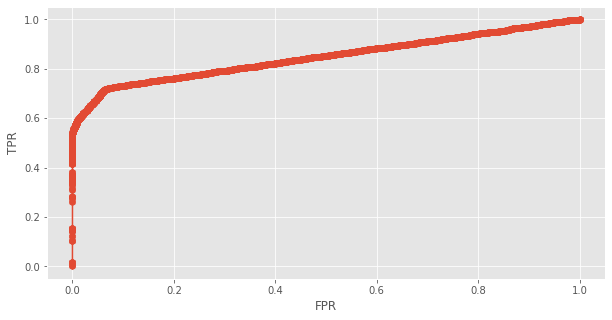

In [37]:
plt.figure(figsize=(10,5))
plt.plot(roc.FPR,roc.TPR,marker='h')
plt.xlabel("FPR")
plt.ylabel("TPR")

## Impact of FP vs. FN

- if __false positive__ cost much higher, we should increase the probability threshold, but pay the price TPR is also decreased.
- if __false negative__ cost much higher, we should decrease the probability threshold, but pay the price FPR is also increased.

In [38]:
roc.loc[ (roc.TPR >= 0.78) & (roc.TPR <=0.83),:]

,FPR,TPR,Threshold
1904,0.262268,0.780343,0.045601
1905,0.262303,0.780343,0.045601
1906,0.262407,0.780343,0.045600
1907,0.262649,0.780343,0.045596
1908,0.263065,0.780343,0.045595
...,...,...,...
3075,0.423134,0.828961,0.044027
3076,0.423134,0.829311,0.044027
3077,0.423203,0.829311,0.044025
3078,0.423411,0.829661,0.044025


In this case, because normally this "Fraud Detection Model" is often used in a pre-screening step, whose result will be further investigated by expert, so

- if 'Not Fraud' is classified as 'Fraud', human expert can still have method to fix the problem
- but if 'Fraud' is classified as 'Not Fraud', the company will lose money directly.

so in this case, "false negative" cost much higher, so we should choose a relatively smaller threshold.

## Question 3

Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classiﬁed as at risk? What are their characteristics

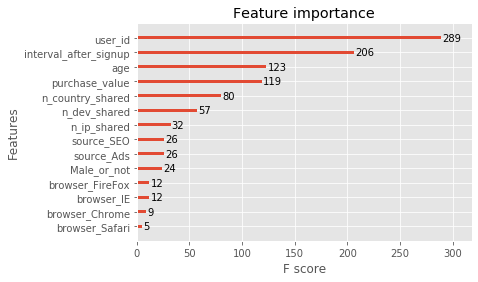

In [39]:
# first we plot the feature importance from GBM
xgb.plot_importance(gbt)

from above model, we can see that, 'interval_after_signup' is the most important factor helping us to decide a transaction is fraud or not.

To better understand, we fit a shallow, simple Decision Tree and plot it.

In [42]:
dt = DecisionTreeClassifier(max_depth=3,min_samples_leaf=20,min_samples_split=20)
dt.fit(X,y)
export_graphviz(dt,feature_names=X.columns,class_names=['NotFraud','Fraud'],
                proportion=True,leaves_parallel=True,filled=True)

'digraph Tree {\nnode [shape=box, style="filled", color="black"] ;\ngraph [ranksep=equally, splines=polyline] ;\n0 [label="interval_after_signup <= 69.0\\ngini = 0.17\\nsamples = 100.0%\\nvalue = [0.906, 0.094]\\nclass = NotFraud", fillcolor="#e88e4d"] ;\n1 [label="gini = 0.0\\nsamples = 5.0%\\nvalue = [0.0, 1.0]\\nclass = Fraud", fillcolor="#399de5"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="n_dev_shared <= 1.5\\ngini = 0.087\\nsamples = 95.0%\\nvalue = [0.954, 0.046]\\nclass = NotFraud", fillcolor="#e68742"] ;\n0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;\n3 [label="interval_after_signup <= 8770937.0\\ngini = 0.059\\nsamples = 87.2%\\nvalue = [0.97, 0.03]\\nclass = NotFraud", fillcolor="#e6853f"] ;\n2 -> 3 ;\n4 [label="gini = 0.058\\nsamples = 73.7%\\nvalue = [0.97, 0.03]\\nclass = NotFraud", fillcolor="#e6853f"] ;\n3 -> 4 ;\n5 [label="gini = 0.065\\nsamples = 13.5%\\nvalue = [0.966, 0.034]\\nclass = NotFraud", fillcolor="#e68540"]

from above plot, we focus on two leaf-nodes

the blue leaf node indicates, if 'interval_after_signup' is <=69 seconds, which means the customer purchases immediatelly after signup, then there is very high probability that this transaction is fraud.
the leaf-node with positive ratio=23% (the second node from right), if the purchase is from a device shared by 2~4 users, then there is above-normal probability that the transaction is fraud.

## Question 4

Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of diﬀerent user experiences would you build based on the model output?

since my model can predict the probability a purchase is fraud, so I need to set two probability cutoffs as 'alert value', alert1 and alert2, and alert1 < alert2 .

for a incoming purchase, my model will return the probability 'p' that the purchase is fraud,

- if p < alert1, then I assume the purchase is normal, proceed without any problem
- if alert1 <= p < alert2, then I assume the purchase is suspicious, I will ask the customer for additional authroization. for example, send email or SMS to the customer, let him/her authorize the purchase.
- if p>= alert2, then the purchase is highly suspicious, I not only ask the customer for additional authorization via email or SMS, but also put the purchase on hold and send the purchase information to some human expert for further investigation.

## Other ML methods:

In [43]:
X = data.loc[:,data.columns != 'is_fraud']
y = data.is_fraud

# split into training dataset and test dataset
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3)

### Random Forest

In [44]:
pipeline = Pipeline(steps = [('clf', RandomForestClassifier(criterion = 'entropy'))])

In [45]:
clf_forest = RandomForestClassifier(n_estimators= 20, criterion = 'entropy', max_depth= 50, min_samples_leaf= 3,min_samples_split= 3, oob_score= True)

In [47]:
clf_forest.fit(Xtrain, ytrain)

F:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
F:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [48]:
preds = clf_forest.predict(Xtest)
preds

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [49]:
print(classification_report(ytest, preds))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     41109
           1       0.99      0.54      0.70      4225

    accuracy                           0.96     45334
   macro avg       0.97      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334



In [52]:
clf_forest.oob_score_

0.9552742536255175

In [56]:
print('Train set prediction accuracy is:',clf_forest.score(Xtrain,ytrain))
print('Test set prediction accuracy is:',clf_forest.score(Xtest,ytest))

Train set prediction accuracy is: 0.961872979258447
Test set prediction accuracy is: 0.9570741606741078


In [54]:
import pandas as pd
feature_imp = pd.Series(clf_forest.feature_importances_,
       index=Xtrain.columns).sort_values(ascending=False)
feature_imp

interval_after_signup    0.340063
n_dev_shared             0.212109
n_ip_shared              0.143761
user_id                  0.092943
purchase_value           0.073044
age                      0.062428
n_country_shared         0.044445
Male_or_not              0.007335
source_Ads               0.005824
source_SEO               0.004825
browser_Chrome           0.003663
browser_IE               0.003575
browser_FireFox          0.003024
browser_Safari           0.002959
dtype: float64

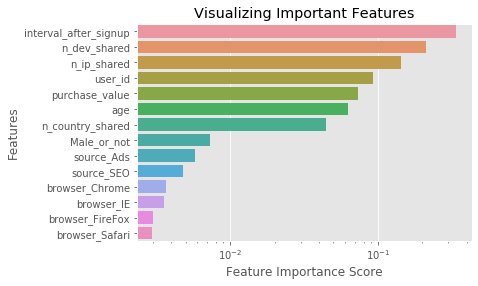

In [55]:
# Visualize feature importance
a=sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
a.set_xscale('log')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()